### Clone metatune Repository for Automatic Model Selection and Hyperparameter tuning

In [30]:
import os
if not os.path.isdir("metatune"):
    print("Cloning https://github.com/ches-001/metatune repository...")
    os.system("git clone https://github.com/ches-001/metatune")
    print("Cloning completed.")

In [31]:
import optuna, warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score, 
    recall_score, 
    precision_score, 
    accuracy_score, 
    roc_auc_score,
    precision_recall_curve, 
    roc_curve,
    confusion_matrix,
)
from metatune import MetaTune
from typing import Tuple, Iterable

warnings.filterwarnings("ignore")

### Load Dataset

In [32]:
TRAIN_DATA_PATH = "data/train.csv"
TEST_DATA_PATH = "data/test.csv"

In [33]:
train_df = pd.read_csv(TRAIN_DATA_PATH)

### Explore Dataset

In [34]:
train_df.head(2)

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,registry,MZ,printables,avlength,file_type_trid,file_type_prob_trid,A,B,C,label
0,a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...,6744064,6799360.0,524.0,3.0,0.0,1.0,1.0,0.0,1.0,...,0.0,28.0,899075.0,13.857079,Win32 EXE PECompact compressed (generic),64.2,-3.978981,5.732354,er,1
1,ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...,22016,45056.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,856.0,9.617978,Win32 Dynamic Link Library (generic),38.4,7.064133,5.738201,er,0


In [35]:
train_df.insert(len(train_df.columns)-2, "file_type_trid", train_df.pop("file_type_trid"))

In [36]:
train_df.head(2)

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,registry,MZ,printables,avlength,file_type_prob_trid,A,B,C,file_type_trid,label
0,a5d72c609a1594621e8eb775e7324d4fc291d5569cfefd...,6744064,6799360.0,524.0,3.0,0.0,1.0,1.0,0.0,1.0,...,0.0,28.0,899075.0,13.857079,64.2,-3.978981,5.732354,er,Win32 EXE PECompact compressed (generic),1
1,ccaa49b76e6fd84842399c4389e2086a5a3687dfabbf01...,22016,45056.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,856.0,9.617978,38.4,7.064133,5.738201,er,Win32 Dynamic Link Library (generic),0


In [37]:
train_df.shape

(60000, 24)

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   sha256               60000 non-null  object 
 1   size                 60000 non-null  int64  
 2   vsize                58065 non-null  float64
 3   imports              58261 non-null  float64
 4   exports              57907 non-null  float64
 5   has_debug            57073 non-null  float64
 6   has_relocations      56676 non-null  float64
 7   has_resources        58039 non-null  float64
 8   has_signature        58063 non-null  float64
 9   has_tls              57102 non-null  float64
 10  symbols              57344 non-null  float64
 11  numstrings           57282 non-null  float64
 12  paths                56340 non-null  float64
 13  urls                 57651 non-null  float64
 14  registry             57475 non-null  float64
 15  MZ                   56911 non-null 

In [39]:
train_df.isna().sum()

sha256                    0
size                      0
vsize                  1935
imports                1739
exports                2093
has_debug              2927
has_relocations        3324
has_resources          1961
has_signature          1937
has_tls                2898
symbols                2656
numstrings             2718
paths                  3660
urls                   2349
registry               2525
MZ                     3089
printables             2739
avlength               2757
file_type_prob_trid       0
A                      3704
B                      3751
C                      2051
file_type_trid            0
label                     0
dtype: int64

### Drop NaN Values

In [40]:
train_df = train_df.dropna(axis=0, how="any")

### Visualise Label Count

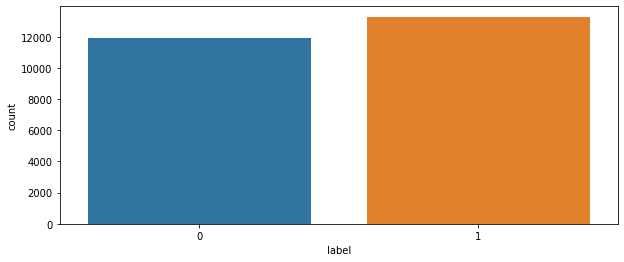

In [41]:
plt.figure(figsize=(10, 4))
sns.countplot(train_df, x="label")
plt.show()

### Visualise Outliers with Box Plot

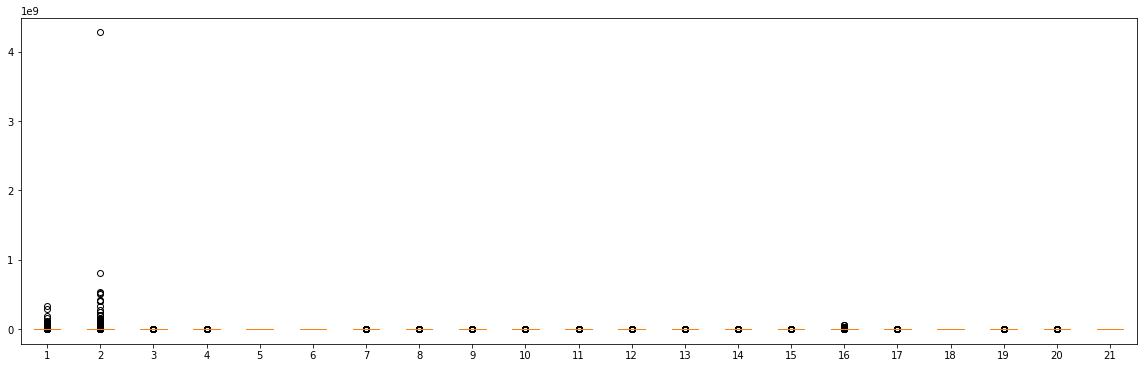

In [77]:
plt.figure(figsize=(20, 6))
plt.boxplot(train_df.drop(columns=["sha256", "file_type_trid", "C"]))
plt.show()

### Sample and Split Data subset to X and y

In [42]:
sample_train_df = train_df.sample(frac=0.025, random_state=42)
sample_X, sample_y = sample_train_df.drop(columns=["label", "sha256"]), sample_train_df["label"]

print(sample_X.shape), print(sample_y.shape)

(630, 22)
(630,)


(None, None)

### Split Subset into Train, Validation and Test Sets

In [43]:
X_train, X_val, y_train, y_val = train_test_split(sample_X, sample_y, shuffle=True, random_state=42, train_size=0.8)

### Create Custom Scaler Class to Scale Data

In [44]:
class CustomScaler:
    def __init__(self):
        self.file_type_label_encoder = LabelEncoder()
        self.c_label_encoder = LabelEncoder()
        self.num_scaler = MinMaxScaler()

    def fit(self, X: pd.DataFrame, c_labels: Iterable[str], file_type_labels: Iterable[str]):
        num_values, _, _ = self._get_values(X)
        self.num_scaler.fit(num_values)
        self.c_label_encoder.fit(c_labels)
        self.file_type_label_encoder.fit(file_type_labels)
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        num_values, c_values, file_type_values = self._get_values(X)

        scaled_num_values = self.num_scaler.transform(num_values)
        encoded_c_values = self.c_label_encoder.transform(c_values).reshape(-1, 1)
        encoded_file_type_values = self.file_type_label_encoder.transform(file_type_values).reshape(-1, 1)
        
        transformed = np.concatenate((scaled_num_values, encoded_c_values, encoded_file_type_values), axis=1)
        transformed = pd.DataFrame(data=transformed, columns=X.columns)
        return transformed


    def _get_values(self, X: pd.DataFrame) -> Tuple[pd.Series, pd.Series, pd.Series]:
        num_values = X.iloc[:, :-2]
        c_values = X["C"]
        file_type_values = X["file_type_trid"]
        return num_values, c_values, file_type_values

In [45]:
scaler = CustomScaler()
scaler.fit(X_train, train_df["C"], train_df["file_type_trid"])
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

X_val.head()

,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,...,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,C,file_type_trid
0,0.000574,0.000932,0.024433,0.000686,1.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.001686,0.001638,0.037877,0.769821,-0.015076,0.752398,5.0,69.0
1,0.080124,0.069602,0.163244,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.025295,0.098609,0.017645,0.023018,0.266743,0.893249,4.0,58.0
2,0.015913,0.015292,0.122167,0.000000,1.0,0.0,1.0,1.0,0.0,0.0,...,0.042254,0.0,0.005059,0.007605,0.032325,0.510230,0.435562,0.800369,1.0,69.0
3,0.039097,0.079959,0.060907,0.000000,0.0,1.0,1.0,1.0,0.0,0.0,...,0.093897,0.0,0.053963,0.030521,0.003314,0.326087,0.245735,0.991969,5.0,58.0
4,0.028998,0.024083,0.087465,0.000000,1.0,1.0,1.0,1.0,1.0,0.0,...,0.091549,0.0,0.011804,0.052691,0.057193,0.791560,0.461386,0.858958,5.0,73.0


### Compute Principle Components of X_train and visualise first 3 components

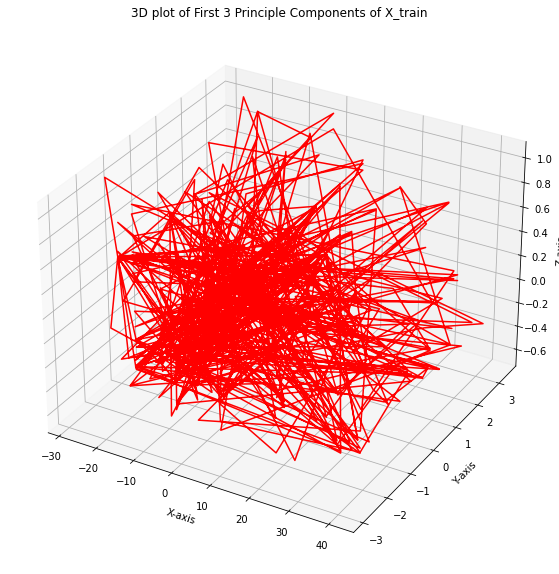

In [46]:
pca_model = PCA(n_components=5)
pca_components = pca_model.fit_transform(X_train)

fig = plt.figure(figsize=(50, 10))
ax = plt.axes(projection='3d')

ax.plot3D(pca_components[:, 0], pca_components[:, 1], pca_components[:, 3], 'red')
ax.set_title("3D plot of First 3 Principle Components of X_train")
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

### Instantiate MetaTune Class for Model Selection and Hyperparameter Tuning.

In [47]:
metatune = MetaTune(task="classification")

### Define Objective Function

In [48]:
def objective(trial: optuna.trial.Trial):
    model = metatune.sample_models_with_params(trial)

    try:
        model.fit(X_train, y_train)
        pred = model.predict(X_val)
        model.predict_proba(X_val)
    except Exception as e:
        raise optuna.exceptions.TrialPruned(e)
    
    f1 = f1_score(y_val, pred, average="binary")
    recall = recall_score(y_val, pred, average="binary")
    precision = precision_score(y_val, pred, average="binary")

    if trial.should_prune():
        raise optuna.exceptions.TrialPruned()
    return (f1 + recall + precision) / 3


# create optuna study
study = optuna.create_study(
    study_name="classifier_model",
    direction="maximize",
    pruner=optuna.pruners.MedianPruner(),
    sampler=optuna.samplers.TPESampler(seed=42),
)

study.optimize(objective, n_trials=100)

[I 2023-06-25 16:18:34,925] A new study created in memory with name: classifier_model
[I 2023-06-25 16:18:34,970] Trial 0 finished with value: 0.7050602995864178 and parameters: {'model_tuner': 'AdaBoostClassifierTuner', 'AdaBoostClassifierTuner_estimator': None, 'AdaBoostClassifierTuner_n_estimators': 2, 'AdaBoostClassifierTuner_learning_rate': 0.10677482709481352, 'AdaBoostClassifierTuner_algorithm': 'SAMME', 'AdaBoostClassifierTuner_random_state': 205}. Best is trial 0 with value: 0.7050602995864178.
[I 2023-06-25 16:18:35,037] Trial 1 finished with value: 0.7278662061270756 and parameters: {'model_tuner': 'CategoricalNBTuner', 'CategoricalNBTuner_alpha': 0.1959828624191452, 'force_alpha': False, 'fit_prior': True, 'CategoricalNBTuner_class_prior': None, 'min_categories': None}. Best is trial 1 with value: 0.7278662061270756.
[I 2023-06-25 16:18:35,065] Trial 2 pruned. 'PassiveAggressiveClassifier' object has no attribute 'predict_proba'
[I 2023-06-25 16:18:35,126] Trial 3 finished 

### Build Sampled Model with Sampled Hyperparameters

In [49]:
sampled_model = metatune.build_sampled_model(study.best_trial)

### Fit Sampled Model on Entire Data

In [50]:
X, y = train_df.drop(columns=["label", "sha256"]), train_df["label"]

In [51]:
X_train, X_val, y_train, y_val = train_test_split(X, y, shuffle=True, random_state=42, train_size=0.8)

In [52]:
scaler = CustomScaler()
scaler.fit(X_train, train_df["C"], train_df["file_type_trid"])
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

X_val.head()

,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,...,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,C,file_type_trid
0,0.137423,0.000043,0.008257,0.000000,0.0,0.0,1.0,1.0,1.0,0.0,...,0.004368,0.0,0.084606,0.020253,0.000013,0.333333,0.360443,0.999976,5.0,69.0
1,0.023707,0.001673,0.016513,0.067771,1.0,1.0,1.0,1.0,0.0,0.0,...,0.001065,0.0,0.001427,0.005997,0.000152,0.344322,0.313228,0.912145,3.0,18.0
2,0.003035,0.000207,0.000068,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,...,0.002237,0.0,0.000000,0.001020,0.000246,0.768010,0.310431,0.627318,1.0,15.0
3,0.003689,0.001507,0.000744,0.000000,0.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.0,0.001284,0.000734,0.000023,0.493284,0.482266,0.993925,5.0,40.0
4,0.000065,0.000003,0.000000,0.000791,1.0,0.0,1.0,1.0,0.0,0.0,...,0.002131,0.0,0.000000,0.000100,0.000323,0.300366,0.429766,0.810582,5.0,52.0


In [53]:
sampled_model.fit(X_train, y_train)

BaggingClassifier(max_features=0.90863373669599, max_samples=0.902926979504974,
                  n_estimators=62, random_state=3374)

### Compute and Visualise Performance Metric.

In [54]:
def log_performance_metric(
        y_true: np.ndarray, 
        y_pred: np.ndarray, 
        y_score: np.ndarray, 
        label: str):
    
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_score)
    accuracy = accuracy_score(y_true, y_pred)

    print(
        f"{label} Recall score: {round(recall, 4)}\
        \t{label} Precision score: {round(precision, 4)}\
        \t{label} F1 score: {round(f1, 4)}\
        \t{label} AUC ROC score: {round(auc, 4)}\
        \t{label} Accuracy score: {round(accuracy, 4)}")
    print("-"*150)

In [55]:
train_pred = sampled_model.predict(X_train)
train_proba = sampled_model.predict_proba(X_train)[:, 1]
log_performance_metric(y_train.values, train_pred, train_proba, label="Train")

val_pred = sampled_model.predict(X_val)
val_proba = sampled_model.predict_proba(X_val)[:, 1]
log_performance_metric(y_val.values, val_pred, val_proba, label="Validation")

Train Recall score: 0.9997        	Train Precision score: 1.0        	Train F1 score: 0.9999        	Train AUC ROC score: 1.0        	Train Accuracy score: 0.9999
------------------------------------------------------------------------------------------------------------------------------------------------------
Validation Recall score: 0.914        	Validation Precision score: 0.9397        	Validation F1 score: 0.9267        	Validation AUC ROC score: 0.9777        	Validation Accuracy score: 0.9232
------------------------------------------------------------------------------------------------------------------------------------------------------


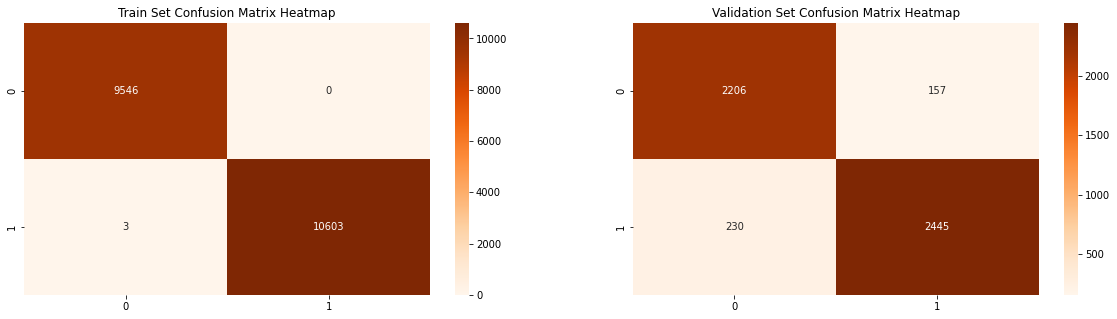

In [56]:
train_cm = confusion_matrix(y_train.values, train_pred)
val_cm = confusion_matrix(y_val.values, val_pred)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

sns.heatmap(train_cm, annot=True, fmt='d', cmap='Oranges', ax=axs[0])
axs[0].set_title("Train Set Confusion Matrix Heatmap")

sns.heatmap(val_cm, annot=True, fmt='d', cmap='Oranges', ax=axs[1])
axs[1].set_title("Validation Set Confusion Matrix Heatmap")

plt.show()

Text(0, 0.5, 'Recall')

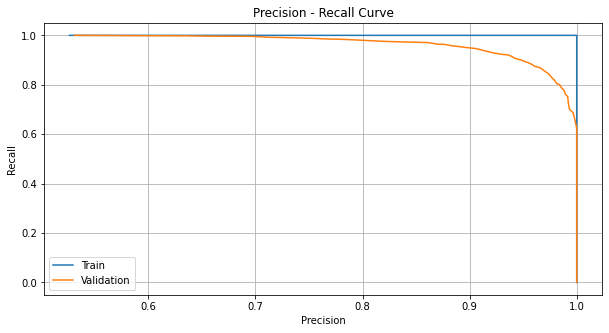

In [57]:
train_precisions, train_recalls, _ = precision_recall_curve(y_train, train_proba)
val_precisions, val_recalls, _ = precision_recall_curve(y_val, val_proba)

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(train_precisions, train_recalls, label="Train")
plt.plot(val_precisions, val_recalls, label="Validation")
plt.title("Precision - Recall Curve")
plt.legend()
plt.xlabel("Precision")
plt.ylabel("Recall")

Text(0, 0.5, 'True Positive Rate')

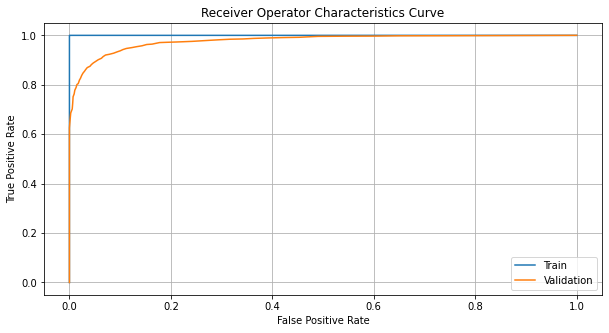

In [58]:
train_fpr, train_tpr, _ = roc_curve(y_train, train_proba)
val_fpr, val_tpr, _ = roc_curve(y_val, val_proba)

plt.figure(figsize=(10, 5))
plt.grid()
plt.plot(train_fpr, train_tpr, label="Train")
plt.plot(val_fpr, val_tpr, label="Validation")
plt.title("Receiver Operator Characteristics Curve")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

### Run Inference on Test data

In [69]:
test_df = pd.read_csv(TEST_DATA_PATH)
test_df.insert(len(test_df.columns)-1, "file_type_trid", test_df.pop("file_type_trid"))
test_df = test_df.dropna(axis=0, how="any")
test_df.head(3)

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,C,file_type_trid
2,038e71f41fdc5edb3a7afc112fb0679a4a5d6d94512055...,3091456,118784.0,124.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,9.0,148608.0,11.072796,24.1,-1.713507,6.103680,vh,InstallShield setup
5,c290de562a688eec1deede227356ce8daa8987721570bc...,2260953,1912832.0,17.0,0.0,0.0,1.0,1.0,0.0,1.0,...,9.0,0.0,11.0,1409629.0,181.606416,33.1,3.747652,5.045848,gow,InstallShield setup
11,5349c232421e9569992f995158442add8053a9189dea7d...,1519616,33681408.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,54449.0,9.149555,64.5,-1.348144,5.022775,vh,Win32 Executable MS Visual C++ (generic)


In [70]:
test_df["file_type_trid"] = test_df["file_type_trid"].apply(lambda val : val if val in scaler.file_type_label_encoder.classes_ else "<unknown>")
scaler.file_type_label_encoder.classes_ = np.append(scaler.file_type_label_encoder.classes_, "<unknown>")
test_df.head(3)

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,C,file_type_trid
2,038e71f41fdc5edb3a7afc112fb0679a4a5d6d94512055...,3091456,118784.0,124.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,9.0,148608.0,11.072796,24.1,-1.713507,6.103680,vh,InstallShield setup
5,c290de562a688eec1deede227356ce8daa8987721570bc...,2260953,1912832.0,17.0,0.0,0.0,1.0,1.0,0.0,1.0,...,9.0,0.0,11.0,1409629.0,181.606416,33.1,3.747652,5.045848,gow,InstallShield setup
11,5349c232421e9569992f995158442add8053a9189dea7d...,1519616,33681408.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,1.0,54449.0,9.149555,64.5,-1.348144,5.022775,vh,Win32 Executable MS Visual C++ (generic)


In [71]:
X_test = test_df.drop(columns=["sha256"])
X_test = scaler.transform(X_test)
X_test.head(3)

,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,symbols,...,urls,registry,MZ,printables,avlength,file_type_prob_trid,A,B,C,file_type_trid
0,0.010909,0.000028,0.008392,0.000023,0.0,1.0,1.0,0.0,0.0,0.0,...,0.000000,0.0,0.001141,0.002952,0.000128,0.073260,0.268827,0.924969,5.0,18.0
1,0.007978,0.000447,0.001151,0.000000,0.0,1.0,1.0,0.0,1.0,0.0,...,0.000959,0.0,0.001427,0.027999,0.003729,0.183150,0.365214,0.760043,3.0,18.0
2,0.005362,0.007873,0.002098,0.000023,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000213,0.0,0.000000,0.001081,0.000088,0.566545,0.275275,0.756446,5.0,58.0


In [72]:
predicted_labels = sampled_model.predict(X_test)
predicted_labels[:5]

array([0, 1, 0, 0, 0], dtype=int64)

In [73]:
test_df["predicted_label"] = predicted_labels
test_df.head(3)

,sha256,size,vsize,imports,exports,has_debug,has_relocations,has_resources,has_signature,has_tls,...,registry,MZ,printables,avlength,file_type_prob_trid,A,B,C,file_type_trid,predicted_label
2,038e71f41fdc5edb3a7afc112fb0679a4a5d6d94512055...,3091456,118784.0,124.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,9.0,148608.0,11.072796,24.1,-1.713507,6.103680,vh,InstallShield setup,0
5,c290de562a688eec1deede227356ce8daa8987721570bc...,2260953,1912832.0,17.0,0.0,0.0,1.0,1.0,0.0,1.0,...,0.0,11.0,1409629.0,181.606416,33.1,3.747652,5.045848,gow,InstallShield setup,1
11,5349c232421e9569992f995158442add8053a9189dea7d...,1519616,33681408.0,31.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,54449.0,9.149555,64.5,-1.348144,5.022775,vh,Win32 Executable MS Visual C++ (generic),0


In [74]:
result_dir = "result"
result_file = "result.csv"

if not os.path.isdir(result_dir):
    os.mkdir(result_dir)

test_df.to_csv(os.path.join(result_dir, result_file), index=False)